# Dataset Visualization

In [1]:
import pandas as pd
import numpy as np
from src.models.utils.data import FoodPricingDataset
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import Compose, Resize, ToTensor
import torch
from typing import Tuple, List
from IPython.display import display, Image
from transformers import AutoTokenizer, PreTrainedTokenizerFast, pipeline

### Length of datasets

We first analyze the size of the dataset and respectively of the train, dev, and test set.

In [2]:
dataset = FoodPricingDataset(
    img_transform=lambda _: _,
    txt_transform=lambda _: _,
    split=None,
)

print(f"The length of the whole dataset is: {len(dataset)} rows")

The length of the whole dataset is: 7061 rows


In [3]:
df = dataset.data

len_dev = len(df[df["split"] == "dev"])
len_test = len(df[df["split"] == "test"])

def print_len(split: str) -> None:
    len_split = len(df[df["split"] == split])
    print(f"Length of {split} set: {len_split} ({round(100*(len_split) / len(dataset))}%)")


for split in ["train", "dev", "test"]:
    print_len(split)

Length of train set: 4942 (70%)
Length of dev set: 1059 (15%)
Length of test set: 1060 (15%)


### Analysis of the training dataset

#### Sample tuples (price, image, text)

In [4]:
img_transform = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
    ]
)

training_data = FoodPricingDataset(
    img_transform=img_transform, txt_transform=lambda x: x, split="train"
)

In [5]:
def save_grid_img(data: FoodPricingDataset, text: bool = False) -> None:
    ncols, nrows = 3, 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    if not text:
        fig.tight_layout()
    sample_idxs = torch.randint(len(data), size=(ncols, nrows))
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

    for row in range(nrows):
        for col in range(ncols):
            sample = data[int(sample_idxs[row, col])]
            axs[row, col].set_title(f"Price: {sample['label'].numpy()[0] / 100:,.2f}€")
            axs[row, col].imshow(sample["img"].permute(1, 2, 0))
            if text:
                textstr = sample["txt"]
                axs[row, col].text(
                    0.05,
                    0.95,
                    textstr,
                    transform=axs[row, col].transAxes,
                    fontsize=11,
                    # horizontalalignment="center",
                    verticalalignment="top",
                    bbox=props,
                    wrap=True,
                )
            axs[row, col].set_axis_off()
    plt.savefig("images/04.01_sample_products.jpg")

In [6]:
def save_multiple_imgs(data: FoodPricingDataset, text: bool = False, n_imgs: int = 9) -> None:
    sample_idxs = torch.randint(len(data), size=(n_imgs,))
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.7)
    
    for i in range(n_imgs):
        fig, ax = plt.subplots(figsize=(4, 4))
        sample = data[int(sample_idxs[i])]
        ax.set_title(f"Price: {sample['label'].numpy()[0] / 100:,.2f}€")
        ax.imshow(sample["img"].permute(1, 2, 0))
        if text:
            textstr = sample["txt"]
            ax.text(
                0.50,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=11,
                horizontalalignment="center",
                verticalalignment="top",
                bbox=props,
                wrap=True,
            )
        ax.set_axis_off()
        prefix = ("0"+str(i+1)) if i<9 else str(i+1)
        fpath = f"images/04.01_sample_img_{prefix}.jpg"
        fig.savefig(fpath)
        plt.close()

# save_multiple_imgs(training_data, text=True, n_imgs=9)

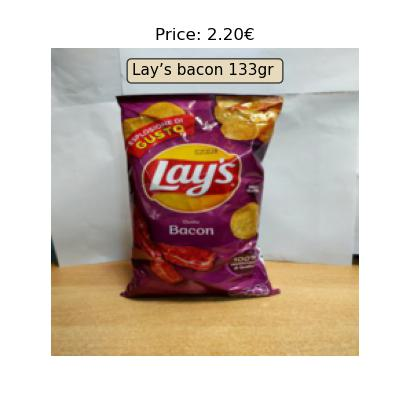

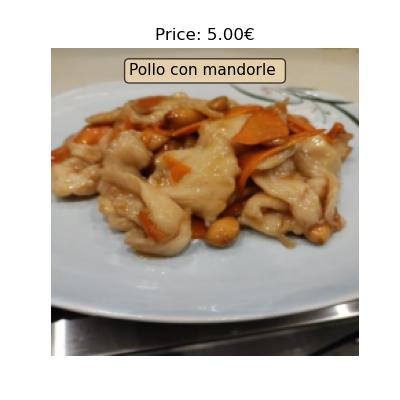

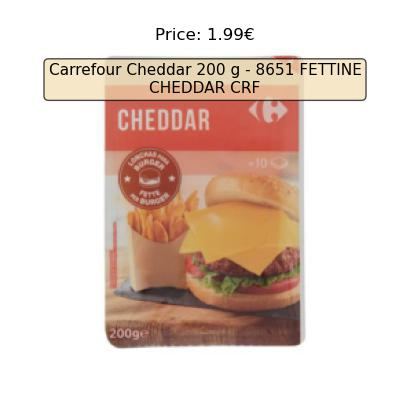

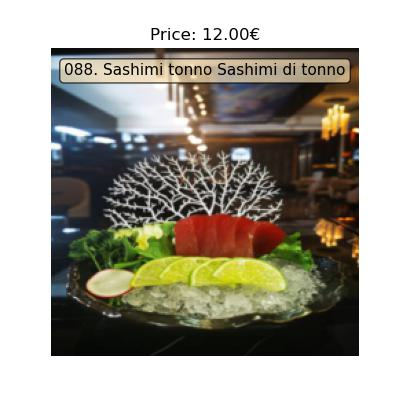

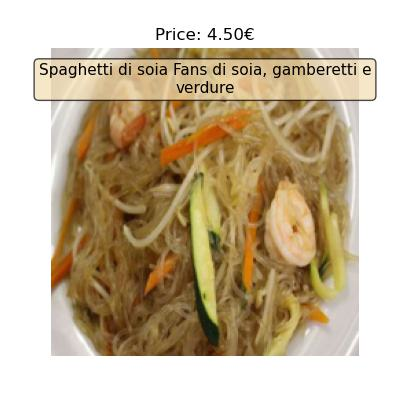

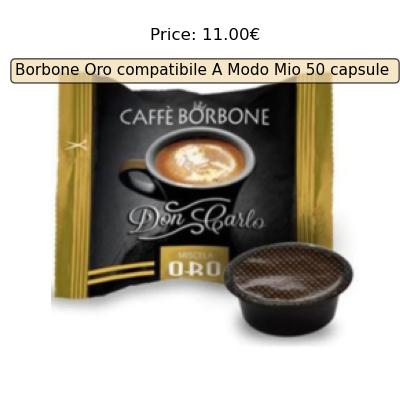

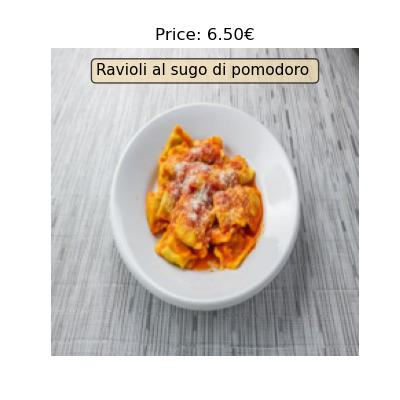

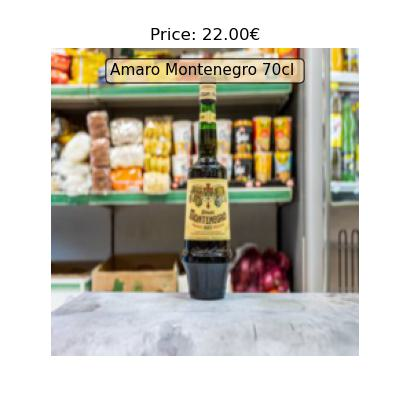

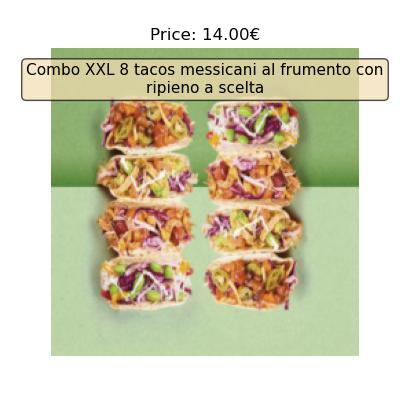

In [7]:
for i in range(9):
    display(Image(filename=f"images/04.01_sample_img_0{i+1}.jpg"))

#### Text analysis

*N.B.: In all the following graphs we do not set a title, as the caption in LaTeX will serve that purpose.*

We first create a list of strings, corresponding to the texts of the products, and we analyse them. 

In [8]:
%matplotlib inline

In [9]:
l_strings = [training_data[i]["txt"] for i in range(len(training_data))]

We plot the distribution of lengths of the strings.

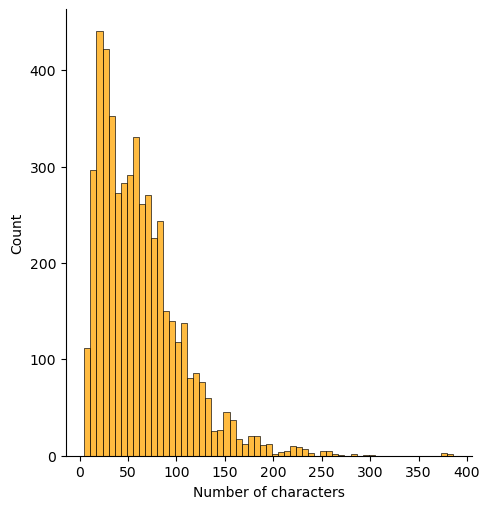

In [10]:
l_lengths = [len(s) for s in l_strings]

disp = sns.displot(l_lengths, color="orange")
disp.set_axis_labels(x_var="Number of characters")
disp.savefig("plots/plt01_distribution_lengths_characters.jpg")

Then, we use the BERT tokenizer to proceed with the analysis of the tokens composing the texts.

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path="dbmdz/bert-base-italian-xxl-uncased"
)

l_tokens = [tokenizer.tokenize(s) for s in l_strings]  # list of lists
l_tokens = [token for sentence in l_tokens for token in sentence] # list

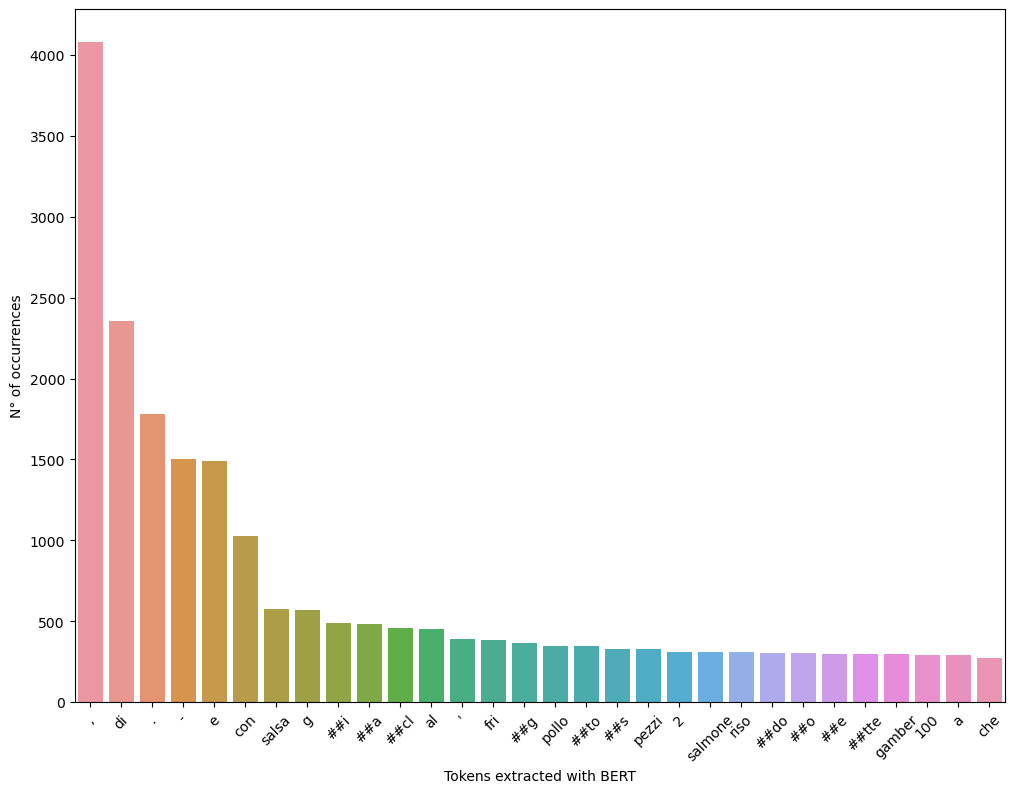

In [12]:
token_counts = pd.Series(l_tokens).value_counts()

fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x=token_counts[:30].index, y=token_counts[:30].values, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_xlabel("Tokens extracted with BERT")
ax.set_ylabel("N° of occurrences")
plt.savefig("plots/plt02_count_tokens.jpg")

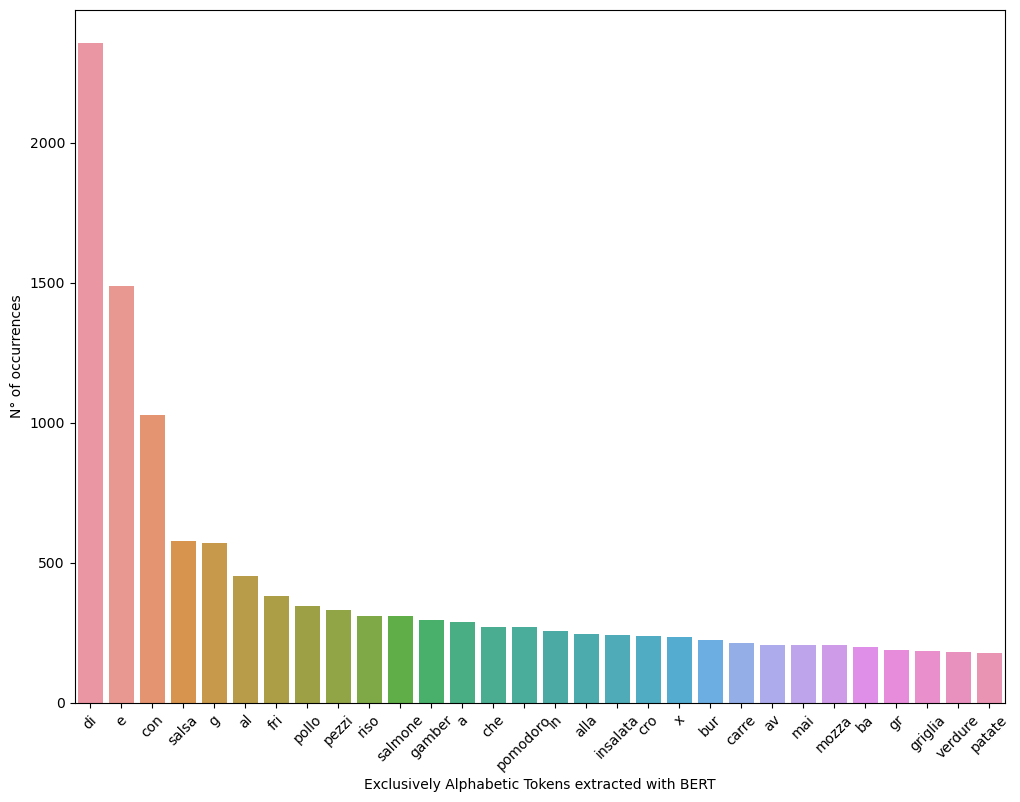

In [13]:
# same but only tokens that contain only letters

l_normaltokens = [token for token in l_tokens if token.isalpha()]

normaltoken_counts = pd.Series(l_normaltokens).value_counts()

fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x=normaltoken_counts[:30].index, y=normaltoken_counts[:30].values, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_xlabel("Exclusively Alphabetic Tokens extracted with BERT")
ax.set_ylabel("N° of occurrences")
plt.savefig("plots/plt03_count_alphabetic_tokens.jpg")

#### Price distribution

In [14]:
prices = [int(training_data[i]["label"]) / 100 for i in range(len(training_data))]

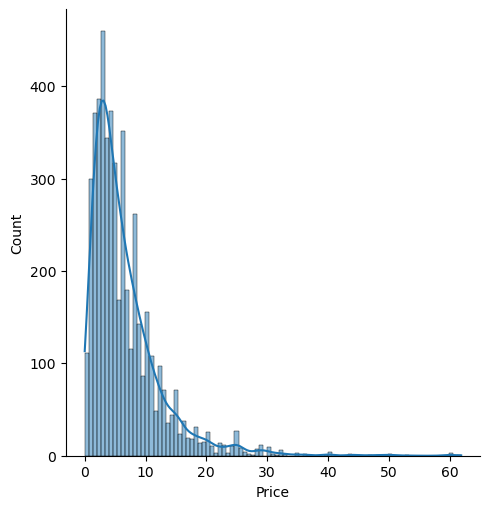

In [15]:
disp = sns.displot(prices, kde=True)
disp.set_axis_labels(x_var="Price")
disp.fig.savefig("plots/plt04_distribution_price.jpg", bbox_inches="tight")

In [16]:
prices = np.array(prices)

prices_statistics = pd.DataFrame(
    [
        {
            # "Count": len(prices),
            "Mean": prices.mean(),
            "Std": prices.std(),
            "Min": prices.min(),
            "1st quartile": np.quantile(prices, .25),
            "Median": np.quantile(prices, .5),
            "3rd quartile":  np.quantile(prices, .75),
            "Max": prices.max(),
        }
    ],
    index=["Price Statistics"],
).T

s = prices_statistics.style.format({("Price Statistics"): "{:.2f}"})
with open("./tables/price_statistics.tex", mode="w") as f:
    s.to_latex(f)
s

,Price Statistics
Mean,6.60
Std,6.01
Min,0.00
1st quartile,2.80
Median,5.00
3rd quartile,8.50
Max,61.90


#### Try a pre-trained model to classify the photos

In [17]:
pipe = pipeline(task="image-classification", model="nateraw/food", top_k=1)

training_data = FoodPricingDataset(
    img_transform=lambda _: _,
    txt_transform=lambda _: _,
    split="train"
)

In [18]:
%%time

l_categories = [pipe(training_data[i]["img"])[0]["label"] for i in range(len(training_data))]

CPU times: user 1h 8min 2s, sys: 47.9 s, total: 1h 8min 50s
Wall time: 8min 38s


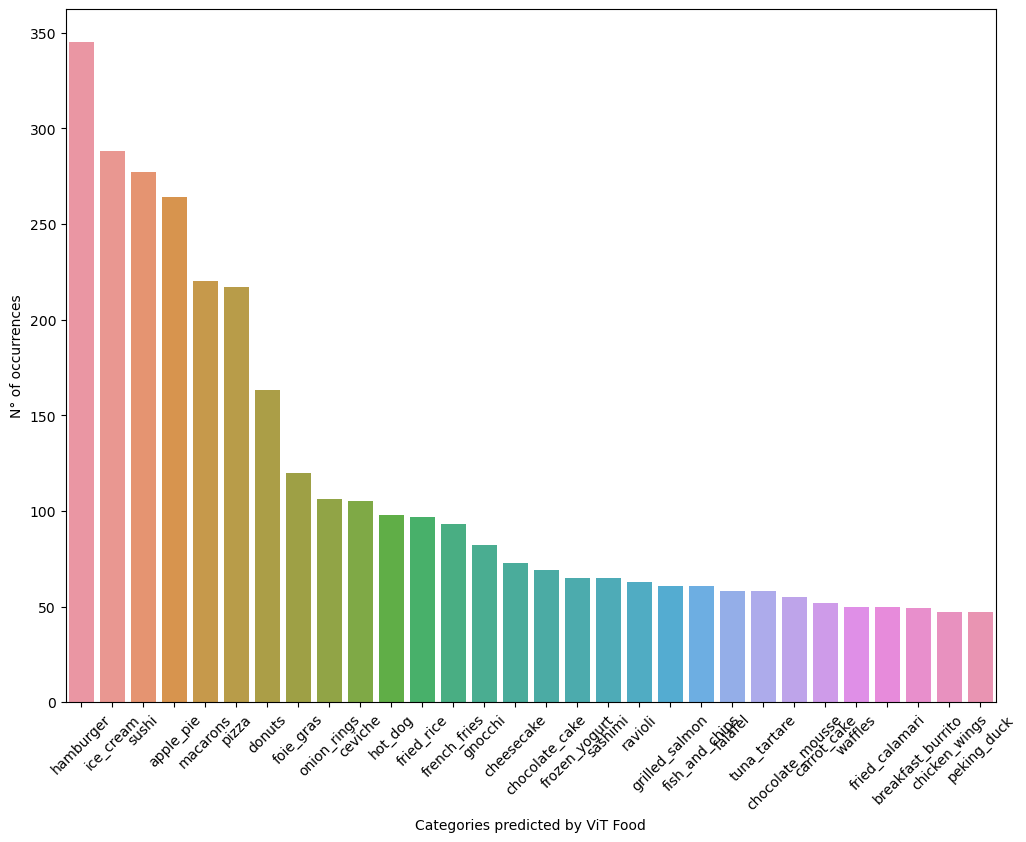

In [19]:
category_counts = pd.Series(l_categories).value_counts()

fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x=category_counts[:30].index, y=category_counts[:30].values, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_xlabel("Categories predicted by ViT Food")
ax.set_ylabel("N° of occurrences")
plt.savefig("plots/plt05_food_categories.jpg")

Finally, we show the geographical areas where the restaurants in the dataset are located.